In [43]:

#Libraries

import plotly.express as px
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet
from prophet import Prophet

In [89]:
import datetime
datetime.datetime.now()

datetime.datetime(2024, 5, 31, 10, 39, 21, 721347)

In [8]:
df=pd.read_csv('archive/DL001.csv',parse_dates=['From Date'],index_col=['From Date'])
df.head()

,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3)
From Date,,,,,,,,,,,
2010-01-01 00:00:00,2010-01-01 01:00:00,NaN,NaN,21.02,41.00,38.75,NaN,4.27,4.43,3.0,NaN
2010-01-01 01:00:00,2010-01-01 02:00:00,NaN,NaN,9.12,29.50,23.25,NaN,4.55,3.69,3.5,NaN
2010-01-01 02:00:00,2010-01-01 03:00:00,NaN,NaN,10.48,27.25,23.25,NaN,4.62,3.68,3.5,NaN
2010-01-01 03:00:00,2010-01-01 04:00:00,NaN,NaN,6.50,24.25,18.25,NaN,4.52,3.11,4.0,NaN
2010-01-01 04:00:00,2010-01-01 05:00:00,NaN,NaN,5.75,21.50,16.25,NaN,4.70,2.80,4.0,NaN


In [9]:
df.columns

Index(['To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
       'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
       'Ozone (ug/m3)', 'Benzene (ug/m3)'],
      dtype='object')

In [10]:
df['To Date']

From Date
2010-01-01 00:00:00    2010-01-01 01:00:00
2010-01-01 01:00:00    2010-01-01 02:00:00
2010-01-01 02:00:00    2010-01-01 03:00:00
2010-01-01 03:00:00    2010-01-01 04:00:00
2010-01-01 04:00:00    2010-01-01 05:00:00
                              ...         
2023-03-31 19:00:00    2023-03-31 20:00:00
2023-03-31 20:00:00    2023-03-31 21:00:00
2023-03-31 21:00:00    2023-03-31 22:00:00
2023-03-31 22:00:00    2023-03-31 23:00:00
2023-03-31 23:00:00    2023-04-01 00:00:00
Name: To Date, Length: 116112, dtype: object

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116112 entries, 2010-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   To Date          116112 non-null  object 
 1   PM2.5 (ug/m3)    76836 non-null   float64
 2   PM10 (ug/m3)     45000 non-null   float64
 3   NO (ug/m3)       85620 non-null   float64
 4   NO2 (ug/m3)      85650 non-null   float64
 5   NOx (ppb)        87090 non-null   float64
 6   NH3 (ug/m3)      62229 non-null   float64
 7   SO2 (ug/m3)      74992 non-null   float64
 8   CO (mg/m3)       63170 non-null   float64
 9   Ozone (ug/m3)    76221 non-null   float64
 10  Benzene (ug/m3)  37609 non-null   float64
dtypes: float64(10), object(1)
memory usage: 10.6+ MB


In [12]:
df.describe()

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3)
count,76836.000000,45000.000000,85620.000000,85650.000000,87090.000000,62229.000000,74992.00000,63170.000000,76221.000000,37609.000000
mean,126.521225,189.108962,43.677767,58.211260,64.744833,58.575492,11.20836,2.189681,29.268231,6.927384
std,103.332900,125.074639,63.839288,58.518263,72.535712,66.292290,11.77704,3.153951,29.545145,11.239515
min,0.250000,1.250000,0.030000,0.100000,0.000000,0.030000,0.02000,0.000000,0.020000,0.000000
25%,54.250000,97.500000,10.250000,23.970000,24.000000,19.790000,4.42000,1.000000,9.130000,0.790000
50%,95.250000,162.750000,20.580000,40.200000,39.920000,33.680000,7.62000,1.580000,18.750000,2.880000
75%,167.500000,250.750000,45.000000,69.500000,73.170000,73.900000,13.65000,2.460000,38.630000,8.590000
max,991.500000,1000.000000,499.350000,499.200000,499.900000,497.850000,196.65000,50.000000,199.750000,233.060000


In [13]:
#df_ts=df.set_index('From Date')
df_ts=df.drop(labels='To Date',axis=1)
df_ts

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3)
From Date,,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,21.02,41.00,38.75,NaN,4.27,4.43,3.00,NaN
2010-01-01 01:00:00,NaN,NaN,9.12,29.50,23.25,NaN,4.55,3.69,3.50,NaN
2010-01-01 02:00:00,NaN,NaN,10.48,27.25,23.25,NaN,4.62,3.68,3.50,NaN
2010-01-01 03:00:00,NaN,NaN,6.50,24.25,18.25,NaN,4.52,3.11,4.00,NaN
2010-01-01 04:00:00,NaN,NaN,5.75,21.50,16.25,NaN,4.70,2.80,4.00,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,26.50,57.00,34.45,49.45,54.32,66.48,7.00,0.82,10.35,6.95
2023-03-31 20:00:00,26.25,60.25,37.92,64.83,65.30,56.25,6.93,1.15,5.03,7.81
2023-03-31 21:00:00,31.25,74.00,40.80,68.10,69.43,67.85,6.88,0.93,8.68,5.04


# Darts Library

In [15]:
series_co= df_ts['CO (mg/m3)']
series_co

From Date
2010-01-01 00:00:00    4.43
2010-01-01 01:00:00    3.69
2010-01-01 02:00:00    3.68
2010-01-01 03:00:00    3.11
2010-01-01 04:00:00    2.80
                       ... 
2023-03-31 19:00:00    0.82
2023-03-31 20:00:00    1.15
2023-03-31 21:00:00    0.93
2023-03-31 22:00:00    0.74
2023-03-31 23:00:00    0.74
Name: CO (mg/m3), Length: 116112, dtype: float64

In [6]:
series_co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116112 entries, 0 to 116111
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   From Date   116112 non-null  object 
 1   CO (mg/m3)  63170 non-null   float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


In [29]:
#resample to eliminate the 46% missing values

series_co=series_co.resample('W',label='right',closed='right').mean().dropna()
series_co

From Date
2010-01-03    4.430000
2010-01-10    5.414737
2010-01-17    3.828968
2010-01-24    6.984600
2010-01-31    4.466439
                ...   
2023-03-05    1.574225
2023-03-12    1.057173
2023-03-19    1.788581
2023-03-26    1.197500
2023-04-02    1.076910
Name: CO (mg/m3), Length: 492, dtype: float64

In [30]:
px.line(series_co)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=CO (mg/m3)<br>From Date=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'CO (mg/m3)',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'CO (mg/m3)',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([datetime.datetime(2010, 1, 3, 0, 0),
                          datetime.datetime(2010, 1, 10, 0, 0),
                          datetime.datetime(2010, 1, 17, 0, 0), ...,
                          datetime.datetime(2023, 3, 19, 0, 0),
                          datetime.datetime(2023, 3, 26, 0, 0),
                          datetime.datetime(2023, 4, 2, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([4.43      , 5.41473653, 3.82896797, ..., 1.78858092, 1.1975    ,
                          1.07691023]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'From Date'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'value'}}}
})

From what we can see let's forget datas before June 2018

In [58]:
#Data Selection from July 2018
co_clean=series_co.loc['2018-06-03':]
co_clean

From Date
2018-06-03    0.725617
2018-06-10    0.903120
2018-06-17    1.148958
2018-06-24    1.045767
2018-07-01    1.310473
                ...   
2023-03-05    1.574225
2023-03-12    1.057173
2023-03-19    1.788581
2023-03-26    1.197500
2023-04-02    1.076910
Name: CO (mg/m3), Length: 253, dtype: float64

In [59]:
co_clean=co_clean.reset_index()
co_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   From Date   253 non-null    datetime64[ns]
 1   CO (mg/m3)  253 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


In [60]:
co_clean

,From Date,CO (mg/m3)
0,2018-06-03,0.725617
1,2018-06-10,0.903120
2,2018-06-17,1.148958
3,2018-06-24,1.045767
4,2018-07-01,1.310473
...,...,...
248,2023-03-05,1.574225
249,2023-03-12,1.057173
250,2023-03-19,1.788581
251,2023-03-26,1.197500


# Prophet

In [61]:
# Preparing the dataset
co_clean=co_clean.rename(columns={'From Date':'ds',
                                  'CO (mg/m3)':'y'})
co_clean

,ds,y
0,2018-06-03,0.725617
1,2018-06-10,0.903120
2,2018-06-17,1.148958
3,2018-06-24,1.045767
4,2018-07-01,1.310473
...,...,...
248,2023-03-05,1.574225
249,2023-03-12,1.057173
250,2023-03-19,1.788581
251,2023-03-26,1.197500


In [62]:
m=Prophet()
m.fit(co_clean)

13:22:58 - cmdstanpy - INFO - Chain [1] start processing


13:22:58 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
future=m.make_future_dataframe(periods=365)
future

,ds
0,2018-06-03
1,2018-06-10
2,2018-06-17
3,2018-06-24
4,2018-07-01
...,...
613,2024-03-28
614,2024-03-29
615,2024-03-30
616,2024-03-31


In [64]:
forecast=m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-06-03,1.333861,0.768845,2.694555,1.333861,1.333861,0.378641,0.378641,0.378641,0.378641,0.378641,0.378641,0.0,0.0,0.0,1.712502
1,2018-06-10,1.339743,0.662875,2.528607,1.339743,1.339743,0.269897,0.269897,0.269897,0.269897,0.269897,0.269897,0.0,0.0,0.0,1.609639
2,2018-06-17,1.345624,0.561068,2.311044,1.345624,1.345624,0.052556,0.052556,0.052556,0.052556,0.052556,0.052556,0.0,0.0,0.0,1.398180
3,2018-06-24,1.351506,0.272772,2.206451,1.351506,1.351506,-0.133222,-0.133222,-0.133222,-0.133222,-0.133222,-0.133222,0.0,0.0,0.0,1.218284
4,2018-07-01,1.357388,0.253476,2.067017,1.357388,1.357388,-0.172091,-0.172091,-0.172091,-0.172091,-0.172091,-0.172091,0.0,0.0,0.0,1.185297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,2024-03-28,1.275151,-0.065094,1.678399,1.228374,1.327004,-0.480533,-0.480533,-0.480533,-0.480533,-0.480533,-0.480533,0.0,0.0,0.0,0.794619
614,2024-03-29,1.274418,-0.059672,1.787452,1.227459,1.326451,-0.458158,-0.458158,-0.458158,-0.458158,-0.458158,-0.458158,0.0,0.0,0.0,0.816261
615,2024-03-30,1.273686,-0.123468,1.761524,1.226544,1.325892,-0.436056,-0.436056,-0.436056,-0.436056,-0.436056,-0.436056,0.0,0.0,0.0,0.837629
616,2024-03-31,1.272953,0.020597,1.783345,1.225629,1.325521,-0.414164,-0.414164,-0.414164,-0.414164,-0.414164,-0.414164,0.0,0.0,0.0,0.858789


/home/j/Desktop/Air_quality_India_kaggle/venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/j/Desktop/Air_quality_India_kaggle/venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



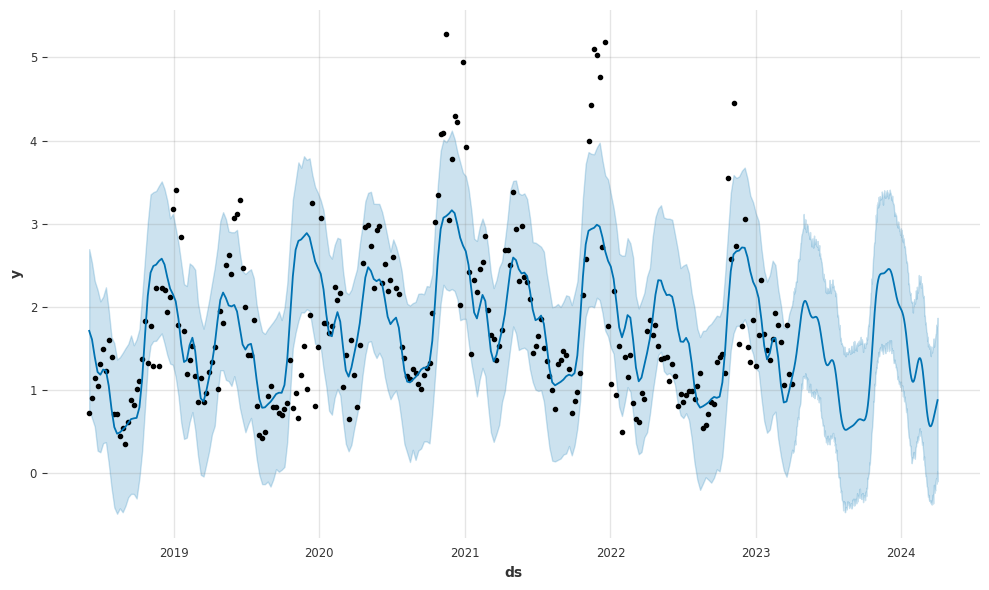

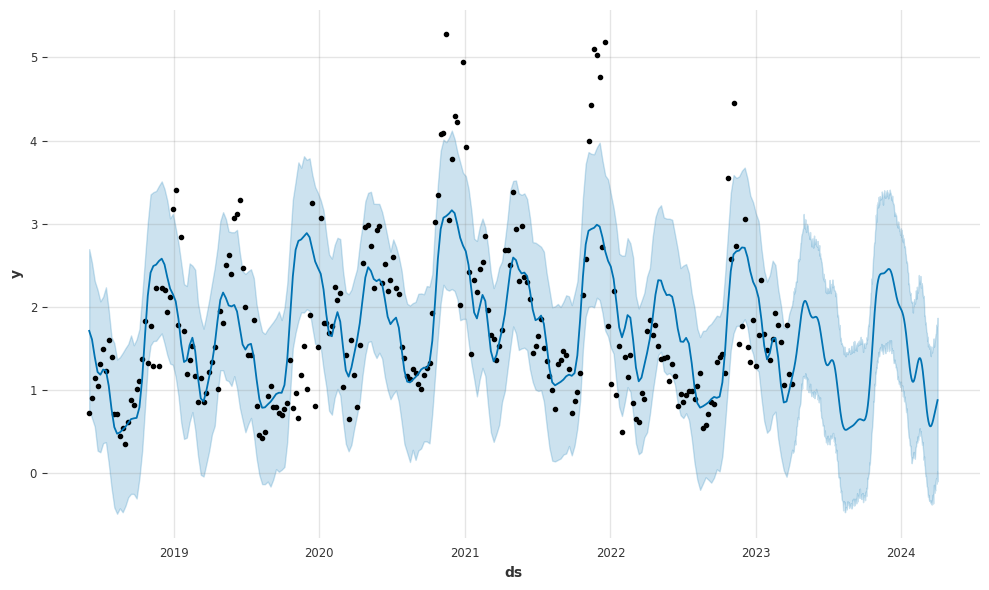

In [65]:
m.plot(forecast)

/home/j/Desktop/Air_quality_India_kaggle/venv/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/j/Desktop/Air_quality_India_kaggle/venv/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/j/Desktop/Air_quality_India_kaggle/venv/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array

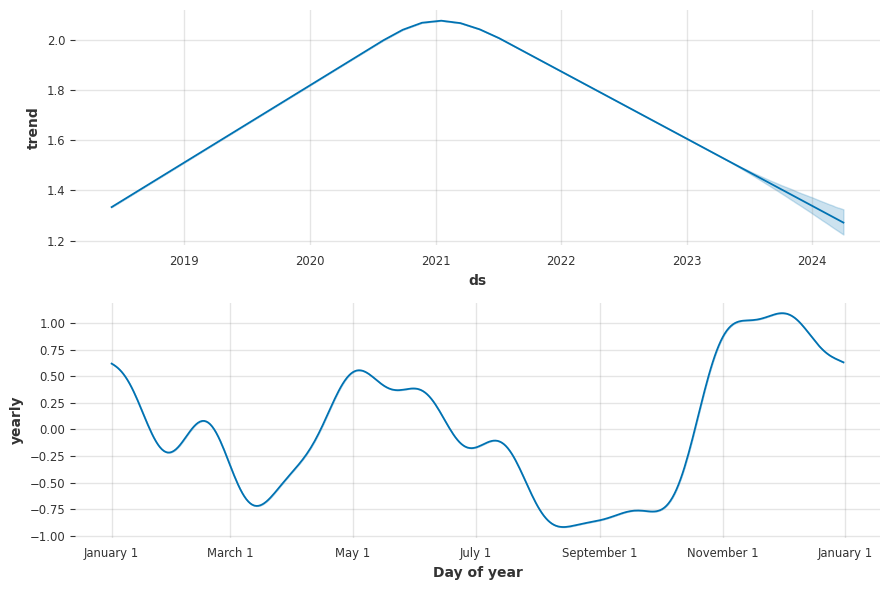

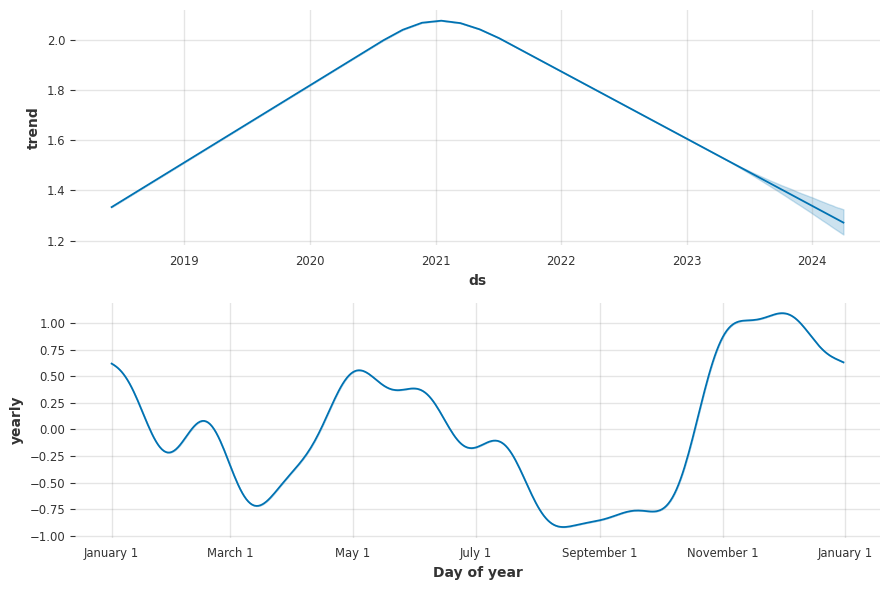

In [66]:
m.plot_components(forecast)

In [67]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m,forecast)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array([datetime.datetime(2018, 6, 3, 0, 0),
                          datetime.datetime(2018, 6, 10, 0, 0),
                          datetime.datetime(2018, 6, 17, 0, 0), ...,
                          datetime.datetime(2023, 3, 19, 0, 0),
                          datetime.datetime(2023, 3, 26, 0, 0),
                          datetime.datetime(2023, 4, 2, 0, 0)], dtype=object),
              'y': array([0.72561705, 0.90311982, 1.14895833, ..., 1.78858092, 1.1975    ,
                          1.07691023])},
             {'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([datetime.datetime(2018, 6, 3, 0, 0),
                          datetime.datetime(2018, 6, 10, 0, 0),
                          datetime.datetime(2018, 6, 17, 0, 0), ...,
                          datetime.datetime(2024, 3, 30, 0, 0),
                          datetime.datetime(2024, 3, 31, 0, 0),
                          datetime.datetime(2024, 4, 1, 0, 0)], dtype=object),
              'y': array([ 0.76884509,  0.66287539,  0.56106805, ..., -0.12346813,  0.02059664,
                          -0.09573787])},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'line': {'color': '#0072B2', 'width': 2},
              'mode': 'lines',
              'name': 'Predicted',
              'type': 'scatter',
              'x': array([datetime.datetime(2018, 6, 3, 0, 0),
                          datetime.datetime(2018, 6, 10, 0, 0),
                          datetime.datetime(2018, 6, 17, 0, 0), ...,
                          datetime.datetime(2024, 3, 30, 0, 0),
                          datetime.datetime(2024, 3, 31, 0, 0),
                          datetime.datetime(2024, 4, 1, 0, 0)], dtype=object),
              'y': array([1.7125019 , 1.60963913, 1.39818009, ..., 0.83762932, 0.85878903,
                          0.87985747])},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([datetime.datetime(2018, 6, 3, 0, 0),
                          datetime.datetime(2018, 6, 10, 0, 0),
                          datetime.datetime(2018, 6, 17, 0, 0), ...,
                          datetime.datetime(2024, 3, 30, 0, 0),
                          datetime.datetime(2024, 3, 31, 0, 0),
                          datetime.datetime(2024, 4, 1, 0, 0)], dtype=object),
              'y': array([2.69455521, 2.52860689, 2.31104411, ..., 1.7615236 , 1.78334503,
                          1.86938783])}],
    'layout': {'height': 600,
               'showlegend': False,
               'template': '...',
               'width': 900,
               'xaxis': {'rangeselector': {'buttons': [{'count': 7, 'label': '1w', 'step': 'day', 'stepmode': 'backward'},
                                                       {'count': 1,
                                                        'label': '1m',
                                                        'step': 'month',
                                                        'stepmode': 'backward'},
                                                       {'count': 6,
                                                        'label': '6m',
                                                        'step': 'month',
                                                        'stepmode': 'backward'},
                                                       {'count': 1, 'label': '1y', 'step': 'year', 'stepmode': 'backward'},
                                                       {'step': 'all'}]},
                         'rangeslider': {'visible': True},